# 电子设备制造业碳排放预测

本notebook使用XGBoost模型对电子设备制造业企业的碳排放量进行预测。

## 1. 导入必要的库

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from utils import ElectronicManufacturingEmissions
import ipywidgets as widgets
from IPython.display import display
import re

# 设置matplotlib显示中文
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 使用SimHei字体显示中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
plt.style.use("ggplot")  # 使用ggplot风格美化图表

# 设置seaborn风格
sns.set(font="SimHei", font_scale=1.2)
sns.set_style("whitegrid", {"font.sans-serif": ["SimHei"]})

## 2. 读取和处理数据集

In [47]:
# 读取数据集
df = pd.read_csv("./datasets/电子设备制造.csv")
df.head()

,企业,年份,化石燃料活动水平,化石燃料排放因子,生产过程排放量,净购入电量,区域电网排放因子,净购入热力,供热排放因子,碳排放量
0,华为电子-深圳,2020,天然气 120万m³,2.75 (天然气),800,"120,000",0.65 (南方电网),3.0,0.07 (天然气锅炉),"1,215,900"
1,富士康-郑州,2021,柴油 200吨,3.15 (柴油),"1,200","180,000",0.72 (华中电网),4.5,0.11 (燃煤锅炉),"2,103,750"
2,台积电-南京,2022,天然气 80万m³,2.75 (天然气),600,"250,000",0.72 (华东电网),2.0,0.07 (天然气锅炉),"2,043,500"
3,京东方-合肥,2023,柴油 150吨,3.15 (柴油),950,"150,000",0.70 (华东电网),3.5,0.11 (燃煤锅炉),"1,654,325"
4,中芯国际-上海,2024,天然气 50万m³,2.75 (天然气),400,"200,000",0.75 (华东电网),1.8,0.07 (天然气锅炉),"1,785,000"


In [48]:
# 查看数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   企业        100 non-null    object 
 1   年份        100 non-null    int64  
 2   化石燃料活动水平  100 non-null    object 
 3   化石燃料排放因子  100 non-null    object 
 4   生产过程排放量   100 non-null    object 
 5   净购入电量     100 non-null    object 
 6   区域电网排放因子  100 non-null    object 
 7   净购入热力     100 non-null    float64
 8   供热排放因子    100 non-null    object 
 9   碳排放量      100 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.9+ KB


In [49]:
# 数据预处理函数
def preprocess_data(df):
    # 创建数据副本
    df_processed = df.copy()

    # 处理化石燃料活动水平
    def extract_fossil_fuel_data(row):
        if "天然气" in row:
            # 提取天然气的数量，单位为万m³
            volume = float(re.search(r"(\d+)万m³", row).group(1))
            return volume, "天然气"
        elif "柴油" in row:
            # 提取柴油的数量，单位为吨
            weight = float(re.search(r"(\d+)吨", row).group(1))
            return weight, "柴油"
        return 0, "unknown"

    # 提取燃料数量和类型
    df_processed["燃料数量"], df_processed["燃料类型"] = zip(
        *df_processed["化石燃料活动水平"].apply(extract_fossil_fuel_data)
    )

    # 处理化石燃料排放因子 - 提取数值
    df_processed["排放因子值"] = (
        df_processed["化石燃料排放因子"].str.extract(r"(\d+\.\d+)").astype(float)
    )

    # 处理生产过程排放量 - 移除逗号并转换为数字
    df_processed["生产过程排放量"] = (
        df_processed["生产过程排放量"].str.replace(",", "").astype(float)
    )

    # 处理净购入电量 - 移除逗号并转换为数字
    df_processed["净购入电量"] = (
        df_processed["净购入电量"].str.replace(",", "").astype(float)
    )

    # 提取区域电网排放因子数值
    df_processed["电网排放因子值"] = (
        df_processed["区域电网排放因子"].str.extract(r"(\d+\.\d+)").astype(float)
    )

    # 提取供热排放因子数值
    df_processed["供热排放因子值"] = (
        df_processed["供热排放因子"].str.extract(r"(\d+\.\d+)").astype(float)
    )

    # 处理碳排放量 - 移除逗号并转换为数字
    df_processed["碳排放量"] = (
        df_processed["碳排放量"].str.replace(",", "").astype(float)
    )

    return df_processed


# 应用预处理
df_processed = preprocess_data(df)
df_processed.head()

,企业,年份,化石燃料活动水平,化石燃料排放因子,生产过程排放量,净购入电量,区域电网排放因子,净购入热力,供热排放因子,碳排放量,燃料数量,燃料类型,排放因子值,电网排放因子值,供热排放因子值
0,华为电子-深圳,2020,天然气 120万m³,2.75 (天然气),800.0,120000.0,0.65 (南方电网),3.0,0.07 (天然气锅炉),1215900.0,120.0,天然气,2.75,0.65,0.07
1,富士康-郑州,2021,柴油 200吨,3.15 (柴油),1200.0,180000.0,0.72 (华中电网),4.5,0.11 (燃煤锅炉),2103750.0,200.0,柴油,3.15,0.72,0.11
2,台积电-南京,2022,天然气 80万m³,2.75 (天然气),600.0,250000.0,0.72 (华东电网),2.0,0.07 (天然气锅炉),2043500.0,80.0,天然气,2.75,0.72,0.07
3,京东方-合肥,2023,柴油 150吨,3.15 (柴油),950.0,150000.0,0.70 (华东电网),3.5,0.11 (燃煤锅炉),1654325.0,150.0,柴油,3.15,0.70,0.11
4,中芯国际-上海,2024,天然气 50万m³,2.75 (天然气),400.0,200000.0,0.75 (华东电网),1.8,0.07 (天然气锅炉),1785000.0,50.0,天然气,2.75,0.75,0.07


## 3. 使用utils.py中的函数计算total_emission

In [50]:
# 根据数据行计算total_emission
def calculate_emission_for_row(row):
    # 准备参数
    # 化石燃料活动水平和排放因子
    AD_fossil_fuel = [row["燃料数量"]]
    EF_fossil_fuel = [row["排放因子值"]]

    # 生产过程排放量
    E_process = row["生产过程排放量"]

    # 净购入电量和区域电网排放因子
    purchased_electricity = row["净购入电量"]
    regional_grid_emission_factor = row["电网排放因子值"]

    # 净购入热力和供热排放因子
    purchased_heat = row["净购入热力"]
    heat_supply_emission_factor = row["供热排放因子值"]

    # 调用utils.py中的函数计算排放量
    total_emission = (
        ElectronicManufacturingEmissions.calculate_electronic_manufacturing_emission(
            AD_fossil_fuel=AD_fossil_fuel,
            EF_fossil_fuel=EF_fossil_fuel,
            E_process=E_process,
            purchased_electricity=purchased_electricity,
            regional_grid_emission_factor=regional_grid_emission_factor,
            purchased_heat=purchased_heat,
            heat_supply_emission_factor=heat_supply_emission_factor,
        )
    )

    return total_emission


# 计算每一行的total_emission
df_processed["计算排放量"] = df_processed.apply(calculate_emission_for_row, axis=1)

# 查看结果
df_processed[["企业", "年份", "计算排放量", "碳排放量"]].head()

,企业,年份,计算排放量,碳排放量
0,华为电子-深圳,2020,79130.210,1215900.0
1,富士康-郑州,2021,131430.495,2103750.0
2,台积电-南京,2022,180820.140,2043500.0
3,京东方-合肥,2023,106422.885,1654325.0
4,中芯国际-上海,2024,150537.626,1785000.0


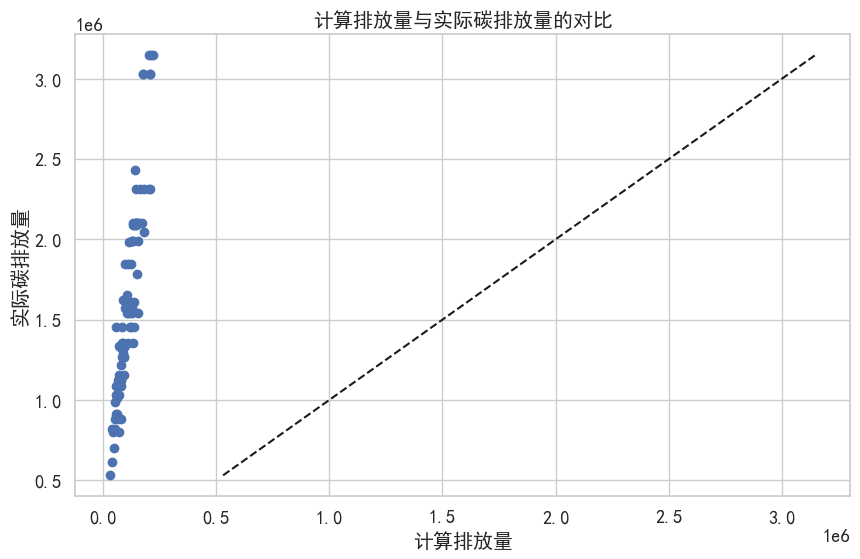

In [51]:
# 比较计算排放量与实际碳排放量
plt.figure(figsize=(10, 6))
plt.scatter(df_processed["计算排放量"], df_processed["碳排放量"])
plt.plot(
    [df_processed["碳排放量"].min(), df_processed["碳排放量"].max()],
    [df_processed["碳排放量"].min(), df_processed["碳排放量"].max()],
    "k--",
)
plt.xlabel("计算排放量")
plt.ylabel("实际碳排放量")
plt.title("计算排放量与实际碳排放量的对比")
plt.grid(True)
plt.show()

## 4. 训练XGBoost模型

In [52]:
# 准备特征和目标变量
X = df_processed[
    [
        "计算排放量",
        "燃料数量",
        "排放因子值",
        "生产过程排放量",
        "净购入电量",
        "电网排放因子值",
        "净购入热力",
        "供热排放因子值",
    ]
]
y = df_processed["碳排放量"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 训练XGBoost模型
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

## 5. 评估模型性能

RMSE: 166642.01
R² Score: 0.9457


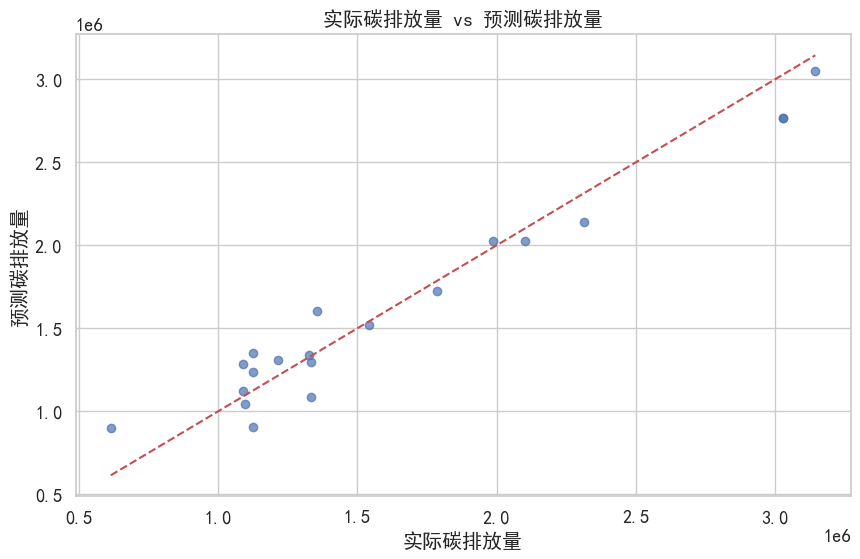

In [53]:
# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("实际碳排放量")
plt.ylabel("预测碳排放量")
plt.title("实际碳排放量 vs 预测碳排放量")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

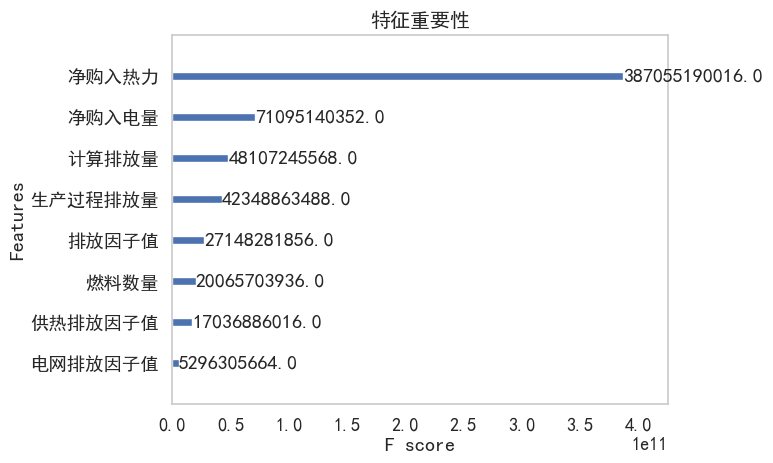

In [54]:
# 特征重要性
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type="gain")
plt.title("特征重要性")
plt.grid(False)
plt.show()

## 6. 创建预测GUI

In [ ]:
# 创建简单的GUI用于预测
def create_prediction_ui():
    # 创建输入部件
    fuel_type = widgets.Dropdown(
        options=["天然气", "柴油"],
        description="燃料类型:",
        disabled=False,
    )

    fuel_amount = widgets.FloatText(
        value=100.0,
        description="燃料数量:",
        tooltip="天然气(万m³)或柴油(吨)",
    )

    emission_factor = widgets.FloatText(
        value=2.75,
        description="排放因子:",
        tooltip="化石燃料排放因子",
    )

    process_emission = widgets.FloatText(
        value=1000.0,
        description="过程排放:",
        tooltip="生产过程排放量",
    )

    electricity = widgets.FloatText(
        value=150000.0,
        description="净购入电量:",
    )

    grid_factor = widgets.FloatText(
        value=0.7,
        description="电网因子:",
        tooltip="区域电网排放因子",
    )

    heat = widgets.FloatText(
        value=3.0,
        description="净购入热力:",
    )

    heat_factor = widgets.FloatText(
        value=0.09,
        description="热力因子:",
        tooltip="供热排放因子",
    )

    output = widgets.Output()

    # 预测按钮和功能
    def on_predict_button_clicked(b):
        with output:
            output.clear_output()

            # 准备数据
            AD_fossil_fuel = [fuel_amount.value]
            EF_fossil_fuel = [emission_factor.value]
            E_process = process_emission.value
            purchased_electricity = electricity.value
            regional_grid_emission_factor = grid_factor.value
            purchased_heat = heat.value
            heat_supply_emission_factor = heat_factor.value

            # 计算排放量
            calculated_emission = ElectronicManufacturingEmissions.calculate_electronic_manufacturing_emission(
                AD_fossil_fuel=AD_fossil_fuel,
                EF_fossil_fuel=EF_fossil_fuel,
                E_process=E_process,
                purchased_electricity=purchased_electricity,
                regional_grid_emission_factor=regional_grid_emission_factor,
                purchased_heat=purchased_heat,
                heat_supply_emission_factor=heat_supply_emission_factor,
            )

            # 使用XGBoost模型预测
            input_data = pd.DataFrame(
                {
                    "计算排放量": [calculated_emission],
                    "燃料数量": [fuel_amount.value],
                    "排放因子值": [emission_factor.value],
                    "生产过程排放量": [process_emission.value],
                    "净购入电量": [purchased_electricity],
                    "电网排放因子值": [regional_grid_emission_factor],
                    "净购入热力": [purchased_heat],
                    "供热排放因子值": [heat_supply_emission_factor],
                }
            )

            predicted_emission = model.predict(input_data)[0]

            print(f"理论计算排放量: {calculated_emission:.2f} tCO2e")
            print(f"模型预测排放量: {predicted_emission:.2f} tCO2e")

    predict_button = widgets.Button(
        description="预测排放量", button_style="success", tooltip="点击预测碳排放量"
    )
    predict_button.on_click(on_predict_button_clicked)

    # 组合UI元素
    input_widgets = widgets.VBox(
        [
            widgets.HBox([fuel_type, fuel_amount]),
            widgets.HBox([emission_factor, process_emission]),
            widgets.HBox([electricity, grid_factor]),
            widgets.HBox([heat, heat_factor]),
            predict_button,
            output,
        ]
    )

    return input_widgets


# 显示预测界面
ui = create_prediction_ui()
display(ui)